In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

root_dir = '/content/gdrive/MyDrive/Data'

Mounted at /content/gdrive


In [4]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from pandas.core.frame import DataFrame
from time import sleep
import math

Extracting labelled and unlabelled dataset

In [6]:
participants = 18
experience = 1

psg_dir = os.path.join(root_dir, "18 participants/PSG")
features_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))

# PSG Files
PSG_Consensus_Sleep_profile = "SDRI001_PSG_Consensus Sleep profile_0"
PSG_Heart_Rate = "SDRI001_PSG_Heart Rate_0"
PSG_HRV_HF = "SDRI001_PSG_HRV HF_0"
PSG_HRV_LF = "SDRI001_PSG_HRV LF_0"
PSG_Position = "SDRI001_PSG_Position_0"
PSG_RR_Interval = "SDRI001_PSG_RR-Interval_0"
PSG_SpO2 = "SDRI001_PSG_SpO2_0"

def get_PSG_dataset(PSF_DIR, PSG_File, participant):
  file_name = os.path.join(PSF_DIR, PSG_File + str(participant).zfill(2) + "V4_N1.txt")
  dataset = pd.read_csv(file_name, sep=" ")
  return dataset

def reformatPSGDatetime(date, time):
  #File 9 Anamoly
  if not isinstance(date, str):
    after_midnight = 0
    if int(time[:2]) < 22:
      after_midnight = 1
    date = str(26+after_midnight) + ".02.2020"

  date = date.split('.')
  time = time.split(',')[0]
  datetime = date[2] + '-' + date[1] + '-' + date[0] + ' ' + time
  return datetime

def extractSleepProfileLabels(dataset, starting_rows=5):
  columns = np.array(dataset.columns)
  columns[0] = 'Date'
  columns[1] = 'Time'
  columns[2] = 'Sleep State'
  dataset.columns = columns
  dataset = dataset.iloc[starting_rows:]
  dataset['Label'] = dataset.apply(lambda x: reformatPSGDatetime(x['Date'], x['Time']), axis=1)
  dataset = dataset[['Label', 'Sleep State']]
  return dataset

def extractNonSleepProfileLabels(dataset, starting_rows=5):
  columns = np.array(dataset.columns)
  columns[0] = 'Date'
  columns[1] = 'Time'
  columns[2] = 'Value'
  columns[3] = 'Sleep State'
  #File 9 Anamoly
  if ',' in dataset.iloc[starting_rows][0]:
    columns[0] = 'Time'
    columns[1] = 'Value'
    columns[2] = 'Sleep State'
    columns[3] = 'Date'
    dataset.columns = columns
    print(dataset.iloc[starting_rows]['Date'])

  dataset.columns = columns
  dataset = dataset.iloc[starting_rows:]
  dataset['Label'] = dataset.apply(lambda x: reformatPSGDatetime(x['Date'], x['Time']), axis=1)
  dataset = dataset[['Label', 'Value', 'Sleep State']]
  return dataset

def get_Features_dataset(features_dir, file="Features.pkl"):
  file_name = os.path.join(features_dir, file)
  dataset = pd.read_pickle(file_name)
  return dataset

def getSection(features_dir):
  file_name = os.path.join(features_dir, "Sections.pkl")
  dataset = pd.read_pickle(file_name)
  dataset = np.array(dataset)
  return dataset.reshape(dataset.shape[0])

def get_Feature_Dataset(sections, features_dataset, participant):
  from_idx = sections[participant-1]
  to_idx = sections[participant]
  return features_dataset.iloc[from_idx:to_idx]

def extract_unlabelled_dataset(feature_dataset, psg_dataset):
  feature_dataset = pd.merge(feature_dataset, psg_dataset, how='left', on="Label")
  return feature_dataset[feature_dataset['Sleep State'].isnull()]

def SaveDataset(dataset, file_name):
  save_file = os.path.join(features_dir, file_name)
  dataset.to_pickle(save_file)

features_dataset = get_Features_dataset(features_dir, "Raw.pkl")
sections = getSection(features_dir)

Extracting labels of Heart rate and Positions dataset


In [5]:
psg_dataset = get_PSG_dataset(psg_dir, PSG_Heart_Rate, 1)
psg_dataset = psg_dataset.reset_index()
psg_dataset = extractNonSleepProfileLabels(psg_dataset, 6)
feature_dataset = get_Feature_Dataset(sections, features_dataset, 1)

labelled_dataset = pd.merge(feature_dataset, psg_dataset, on="Label")
unlabelled_dataset = extract_unlabelled_dataset(feature_dataset, psg_dataset)

for participant in range(2, participants + 1):
  psg_dataset = get_PSG_dataset(psg_dir, PSG_Heart_Rate, participant)
  psg_dataset = psg_dataset.reset_index()
  print(psg_dataset.shape)

  psg_dataset = extractNonSleepProfileLabels(psg_dataset, 6)
  feature_dataset = get_Feature_Dataset(sections, features_dataset, participant)

  new_labelled_dataset = pd.merge(feature_dataset, psg_dataset, on="Label")
  new_unlabelled_dataset = extract_unlabelled_dataset(feature_dataset, psg_dataset)

  labelled_dataset = labelled_dataset.append(new_labelled_dataset, ignore_index=True)
  unlabelled_dataset = unlabelled_dataset.append(new_unlabelled_dataset, ignore_index=True)

SaveDataset(labelled_dataset, "RawLabelledHR")
SaveDataset(unlabelled_dataset, "RawUnlabelledHR")

print(feature_dataset.shape)
print(labelled_dataset.shape)
print(unlabelled_dataset.shape)

NameError: ignored

Extracting labels of Sleep profile dataset

In [8]:
psg_dataset = get_PSG_dataset(psg_dir, PSG_Consensus_Sleep_profile, 1)
psg_dataset = extractSleepProfileLabels(psg_dataset)
feature_dataset = get_Feature_Dataset(sections, features_dataset, 1)

labelled_dataset = pd.merge(feature_dataset, psg_dataset, on="Label")
unlabelled_dataset = extract_unlabelled_dataset(feature_dataset, psg_dataset)

for participant in range(2, participants + 1):
  psg_dataset = get_PSG_dataset(psg_dir, PSG_Consensus_Sleep_profile, participant)
  psg_dataset = extractSleepProfileLabels(psg_dataset)
  feature_dataset = get_Feature_Dataset(sections, features_dataset, participant)

  new_labelled_dataset = pd.merge(feature_dataset, psg_dataset, on="Label")
  new_unlabelled_dataset = extract_unlabelled_dataset(feature_dataset, psg_dataset)

  labelled_dataset = labelled_dataset.append(new_labelled_dataset, ignore_index=True)
  unlabelled_dataset = unlabelled_dataset.append(new_unlabelled_dataset, ignore_index=True)

SaveDataset(labelled_dataset, "RawLabelled")
SaveDataset(unlabelled_dataset, "RawUnlabelled")

print(psg_dataset.shape)
print(feature_dataset.shape)
print(labelled_dataset.shape)
print(unlabelled_dataset.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(1202, 2)
(16763, 9)
(19209, 10)
(496171, 10)


PseudoLabeling module

In [10]:
experience = 1

features_dir = os.path.join(root_dir, "18 participants/AX3/TransformedData" + str(experience))
file_name = os.path.join(features_dir, "RawLabelled")

def encode_sleep_stage(val):
  arr = {'N1':0, 'N2':1, 'N3':2, 'REM':3, 'Wake':4, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

def encode_sleep_state(val):
  arr = {'N1':0, 'N2':1, 'N3':2, 'REM':3, 'Wake':4, 'Artefact':np.NaN, 'A':np.NaN}
  return arr[val]

dataset = pd.read_pickle(file_name)
dataset['Sleep State'] = dataset['Sleep State'].apply(lambda x: encode_sleep_stage(x))
dataset['Sleep State'] = pd.Series(np.array(dataset['Sleep State'])).interpolate()
dataset['Sleep State'] = np.array(dataset['Sleep State'].replace(to_replace = np.nan, value=4), dtype=np.int64)

CNN Module

1    6536
4    5670
2    2740
0    2140
3    2123
Name: Sleep State, dtype: int64
(19209, 8, 1, 1)
(19209, 5)
Epoch 1/50
17288/17288 [==============================] - 26s 1ms/step - loss: 1.4565 - accuracy: 0.4153 - val_loss: 1.4828 - val_accuracy: 0.4253
Epoch 2/50
17288/17288 [==============================] - 25s 1ms/step - loss: 1.4686 - accuracy: 0.4208 - val_loss: 1.4515 - val_accuracy: 0.4237
Epoch 3/50
17288/17288 [==============================] - 25s 1ms/step - loss: 1.4605 - accuracy: 0.4197 - val_loss: 1.4398 - val_accuracy: 0.4269
Epoch 4/50
17288/17288 [==============================] - 25s 1ms/step - loss: 1.4535 - accuracy: 0.4267 - val_loss: 1.4567 - val_accuracy: 0.4258
Epoch 5/50
17288/17288 [==============================] - 25s 1ms/step - loss: 1.4590 - accuracy: 0.4235 - val_loss: 1.4686 - val_accuracy: 0.4321
Epoch 6/50
17288/17288 [==============================] - 25s 1ms/step - loss: 1.4627 - accuracy: 0.4240 - val_loss: 1.4635 - val_accuracy: 0.4331
Epoch 7/

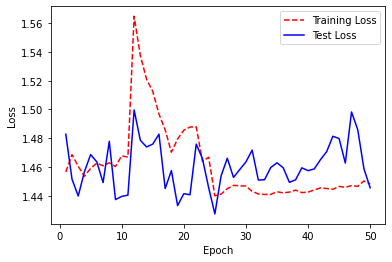

<Figure size 504x504 with 0 Axes>

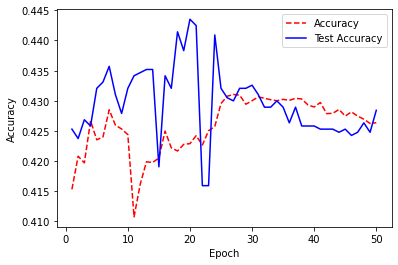

<Figure size 504x504 with 0 Axes>

[[  0 137   0   0  18]
 [  0 643   0   0  64]
 [  0 190   0   0   9]
 [  0 300   0   0  21]
 [  0 359   0   0 180]]
Precision for N1 is 0.0
Precision for N2 is 0.91
Precision for N3 is 0.0
Precision for REM is 0.0
Precision for Wake is 0.33
Accuracy is 0.43


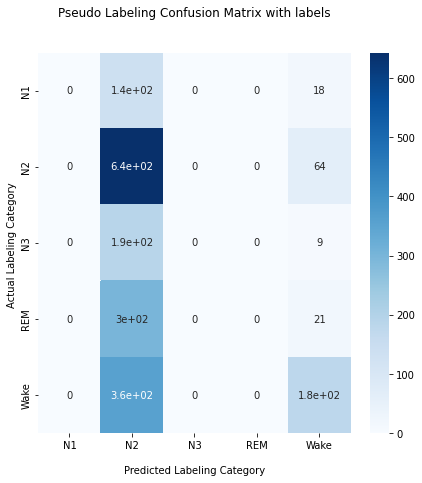

([0.0, 0.91, 0.0, 0.0, 0.33], 0.43)

In [11]:
n = dataset.shape[0]
train_ratio = 0.9
separate_id = int(n * train_ratio)

labels = np.zeros((n,5))

for i in range(n):
  label = dataset.iloc[i]['Sleep State']
  labels[i][label] = 1

print(dataset['Sleep State'].value_counts())
dataset = dataset.drop(['Label', 'Sleep State'], axis=1)
dataset += 0.001
dataset = np.array(dataset)

dataset = dataset.reshape((dataset.shape[0], dataset.shape[1], 1, 1))

x_train = dataset[:separate_id]
y_train = labels[:separate_id]

x_test = dataset[separate_id:]
y_test = labels[separate_id:]

print(dataset.shape)
#print(dataset[0])
print(labels.shape)

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
#create model
model = Sequential()
#add model layers
model.add(Conv2D(8, kernel_size=(1,1), activation='relu', input_shape=(dataset.shape[1],1,1)))
#model.add(MaxPooling2D((1,1)))
model.add(Flatten())
model.add(Dense(6, activation='sigmoid'))
model.add(Dense(5, activation='softmax'))

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
sgd = SGD(learning_rate=0.01)
rms = RMSprop(learning_rate=0.001)
adam = Adam(learning_rate=0.003, epsilon=0.01)
model.compile(optimizer=rms,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=1 ,validation_data=(x_test, y_test), epochs=50)

def plot_graph(x, y, z, x_label, y_label, legends, figsize=(7,7)):
  plt.plot(z, x, 'r--')
  plt.plot(z, y, 'b-')
  plt.legend(legends)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.figure(figsize=figsize)
  plt.show();

history = model.history

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Get training and test loss histories
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

plot_graph(training_loss, test_loss, epoch_count, 'Epoch', 'Loss', ['Training Loss', 'Test Loss'])
plot_graph(accuracy, val_accuracy, epoch_count, 'Epoch', 'Accuracy', ['Accuracy', 'Test Accuracy'])

test_labels = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)
Labels = ['N1','N2', 'N3', 'REM', 'Wake']

printConfusionMatrix(test_labels, y_pred, Labels, show=True)


Result methods

In [9]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns

def convertMultiLabelToSingleLabel(result):
  res = 1
  if result < 4:
    res = 0
  return res

def printConfusionMatrix(test_labels, y_pred, Labels, show=True):
  cf_matrix = confusion_matrix(test_labels, y_pred)
  #cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

  print(cf_matrix)

  precisions = []

  total_vals = 0
  tps = 0
  for i in range(cf_matrix.shape[0]):
    sum_vals = cf_matrix[i].sum()
    total_vals += sum_vals
    tps += cf_matrix[i][i]
    precision = round(cf_matrix[i][i]/sum_vals, 2)
    precisions.append(precision)
    if show:
      print("Precision for " + Labels[i] + " is " + str(precision))

  accuracy = round(tps/total_vals, 2)
  if show:
    print("Accuracy is " + str(accuracy))
    #plot_confusion_matrix(conf_mat=cf_matrix, show_normed=True, figsize=(7,7))

    fig, siz = plt.subplots(figsize=(7,7))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', ax=siz)

    ax.set_title('Pseudo Labeling Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Labeling Category')
    ax.set_ylabel('Actual Labeling Category ');

    ## Ticket labels - List must be in alphabetical order

    ax.xaxis.set_ticklabels(Labels)
    ax.yaxis.set_ticklabels(Labels)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

  return precisions, accuracy